<a href="https://colab.research.google.com/github/IshaaqR/Dog-Breed-Image-Classification/blob/main/Dog_Breed_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Packages

In [1]:
!pip install -q kaggle

In [2]:
import numpy as np
import pandas as pd
import os
from glob import glob
from google.colab import *
import matplotlib.pyplot as plt
import tensorflow as tf

# Load Files

In [3]:
os.environ['KAGGLE_USERNAME'] = "ishaaqrazack" 
os.environ['KAGGLE_KEY'] = "8159d3b4252a9327cfd2ed17a93d6ed1" 

In [4]:
!kaggle competitions download -c 'dog-breed-identification'

100% 689M/691M [00:40<00:00, 18.6MB/s]
100% 691M/691M [00:41<00:00, 17.6MB/s]


In [ ]:
!mkdir dog-breed-identification-data
!unzip dog-breed-identification.zip -d dog-breed-identification-data

In [6]:
!mkdir dog-breed-identification-data/dog_test/
!mkdir dog-breed-identification-data/dog_train/

In [7]:
# Do a train-test split
labels = pd.read_csv('dog-breed-identification-data/labels.csv')
dir_prefix = '/content/dog-breed-identification-data/'

iter_count = 0
train_count = round(labels.shape[0] * 0.8)
test_count = int(labels.shape[0]) - train_count

unique_labels_train = (pd.DataFrame(labels.breed[0:train_count])).drop_duplicates()
unique_labels_test = (pd.DataFrame(labels.breed[train_count:])).drop_duplicates()

for label in unique_labels_train.breed:
  dir = 'dog-breed-identification-data/dog_train/' + label
  os.mkdir(dir)

for label in unique_labels_test.breed:
  dir = 'dog-breed-identification-data/dog_test/' + label
  os.mkdir(dir)

for i in range(train_count):
  start = dir_prefix + 'train/' + str(labels.id[iter_count]) + '.jpg'
  end = dir_prefix + 'dog_train/' + labels.breed[iter_count] + '/' + str(labels.id[iter_count]) + '.jpg'
  os.rename(start, end)
  iter_count += 1

for i in range(test_count):
  start = dir_prefix + 'train/' + str(labels.id[iter_count]) + '.jpg'
  end = dir_prefix + 'dog_test/' + labels.breed[iter_count] + '/' + str(labels.id[iter_count]) + '.jpg'
  os.rename(start, end)
  iter_count += 1

# Data Preprocessing

## Create image datasets from files

In [8]:
BATCH_SIZE = 32
IMG_SIZE = (180, 180)

_URL = 'dog-breed-identification-data/dog_train'

train_dataset = tf.keras.utils.image_dataset_from_directory(_URL, 
                                                            seed=123,
                                                            labels='inferred',
                                                            label_mode='int',
                                                            validation_split=0.2,
                                                            subset='training',
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(_URL, 
                                                            seed=123,
                                                            labels='inferred',
                                                            label_mode='int',
                                                            validation_split=0.2,
                                                            subset='validation',
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

_URL = 'dog-breed-identification-data/dog_test'

test_dataset = tf.keras.utils.image_dataset_from_directory(_URL, 
                                                            seed=123,
                                                            labels='inferred',
                                                            label_mode='int',
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 8178 files belonging to 120 classes.
Using 6543 files for training.
Found 8178 files belonging to 120 classes.
Using 1635 files for validation.
Found 2044 files belonging to 120 classes.


Display some images along with their labels

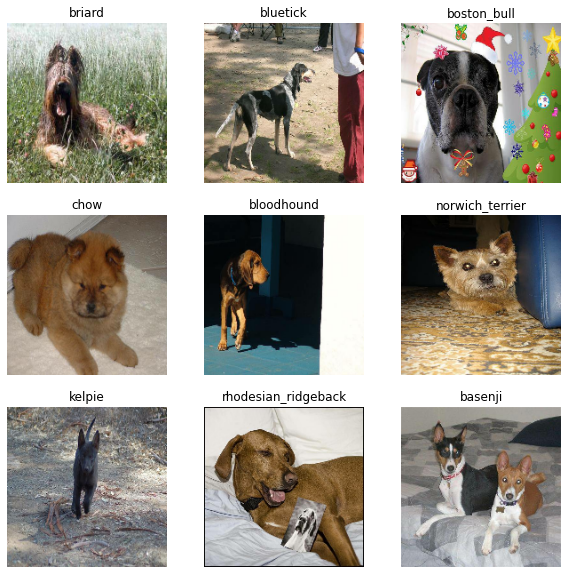

In [9]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  lbl=labels.numpy()
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[lbl[i]])
    plt.axis("off")

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

In [11]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

## Pre-Trained Model

In [12]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [13]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 1280)


In [14]:
base_model.trainable = False

In [15]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 90, 90, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 90, 90, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 90, 90, 32)   0           ['bn_Conv1[0][

## Compile and fit the model

In [16]:
# Hyperparameters
dropout_ratio = 0.1
base_learning_rate = 0.01
optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate)
initial_epochs = 14

In [17]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

In [18]:
prediction_layer = tf.keras.layers.Dense(120)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 120)


In [19]:
# Set up data augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [20]:
inputs = tf.keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(dropout_ratio)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [21]:
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 180, 180, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 180, 180, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 6, 6, 1280)       2257984   
 ional)                                                          
                                                             

In [23]:
# NOTE: it will take extremely long to fit the model using CPU, so use a GPU
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/14
205/205 [==============================] - 21s 87ms/step - loss: 7.3385 - accuracy: 0.2918 - val_loss: 3.0810 - val_accuracy: 0.5670
Epoch 2/14
205/205 [==============================] - 17s 82ms/step - loss: 4.8190 - accuracy: 0.4787 - val_loss: 3.0109 - val_accuracy: 0.6153
Epoch 3/14
205/205 [==============================] - 17s 81ms/step - loss: 4.3683 - accuracy: 0.5384 - val_loss: 3.1961 - val_accuracy: 0.6196
Epoch 4/14
205/205 [==============================] - 17s 81ms/step - loss: 4.2454 - accuracy: 0.5744 - val_loss: 3.4208 - val_accuracy: 0.6214
Epoch 5/14
205/205 [==============================] - 17s 81ms/step - loss: 3.9600 - accuracy: 0.5970 - val_loss: 3.5303 - val_accuracy: 0.6257
Epoch 6/14
205/205 [==============================] - 17s 81ms/step - loss: 3.8839 - accuracy: 0.6089 - val_loss: 3.3826 - val_accuracy: 0.6477
Epoch 7/14
205/205 [==============================] - 17s 82ms/step - loss: 3.6773 - accuracy: 0.6421 - val_loss: 3.6291 - val_accuracy:

# Evaluation and Prediction

In [24]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

64/64 [==============================] - 4s 58ms/step - loss: 4.9280 - accuracy: 0.6433
Test accuracy : 0.64334636926651


## Learning Curves

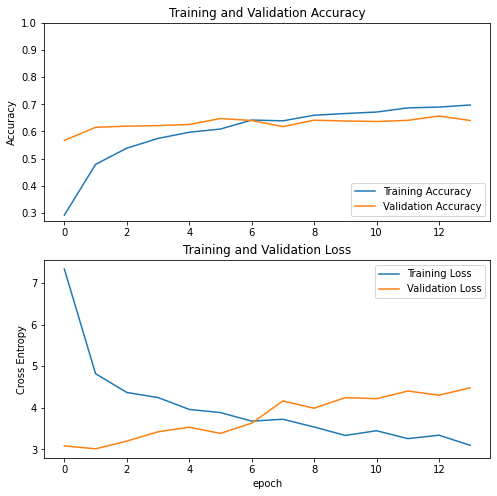

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Test predictions

1/1 [==============================] - 1s 698ms/step


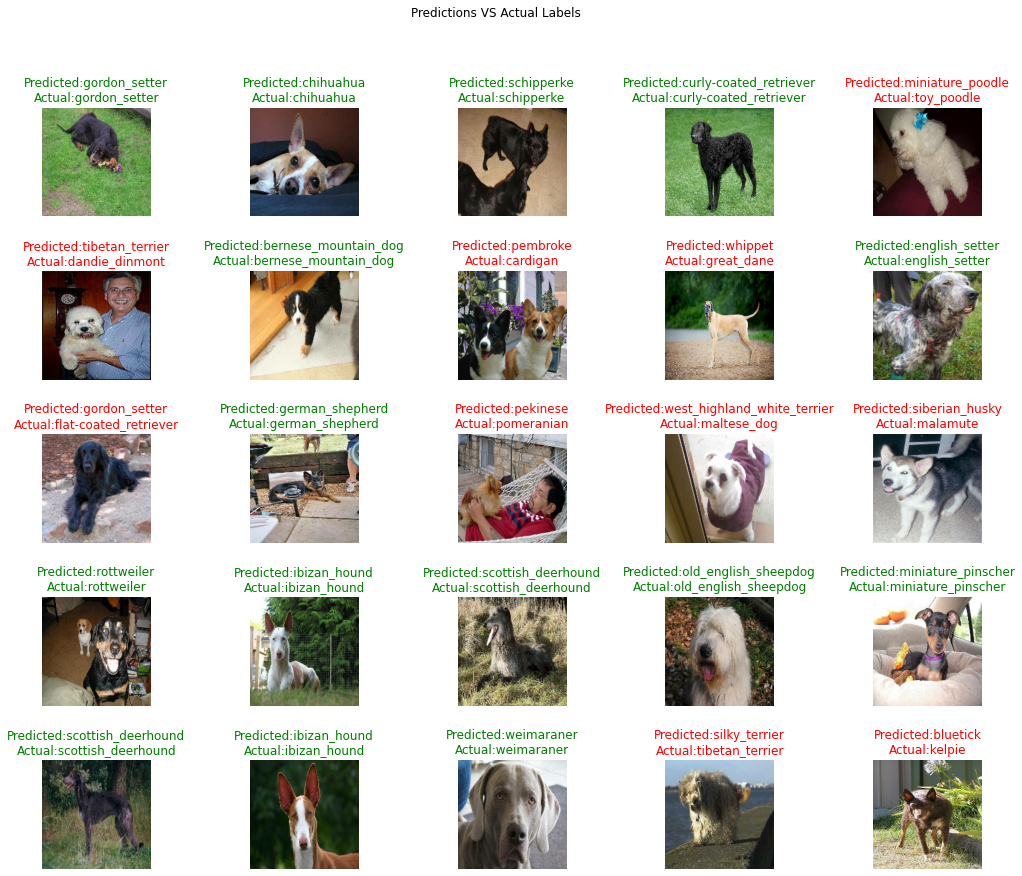

In [26]:
class_names = test_dataset.class_names

plt.figure(figsize=(18, 14))
plt.subplots_adjust(hspace=0.5)

for images, labels in test_dataset.take(1):
  lbl=labels.numpy()

  result_batch = model.predict(images)
  prediction_labels = np.array(tf.math.argmax(result_batch, axis=-1))

  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    is_correct = class_names[prediction_labels[i]] == class_names[lbl[i]]
    color = 'green' if is_correct else 'red'
    plt.title("Predicted:" + class_names[prediction_labels[i]] + "\nActual:" + class_names[lbl[i]], color=color)
    plt.axis("off")
  _ = plt.suptitle("Predictions VS Actual Labels")

# Fine-Tuning
## Un-freeze the top layers of the model

In [27]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [28]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [29]:
len(model.trainable_variables)

56

## Continue training the model

In [30]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 14/24
205/205 [==============================] - 18s 84ms/step - loss: 3.2148 - accuracy: 0.6971 - val_loss: 4.2740 - val_accuracy: 0.6593
Epoch 15/24
205/205 [==============================] - 17s 82ms/step - loss: 3.0028 - accuracy: 0.7122 - val_loss: 4.6111 - val_accuracy: 0.6489
Epoch 16/24
205/205 [==============================] - 17s 81ms/step - loss: 3.0770 - accuracy: 0.7114 - val_loss: 4.5605 - val_accuracy: 0.6563
Epoch 17/24
205/205 [==============================] - 17s 83ms/step - loss: 3.0427 - accuracy: 0.7218 - val_loss: 4.6675 - val_accuracy: 0.6489
Epoch 18/24
205/205 [==============================] - 17s 83ms/step - loss: 2.8760 - accuracy: 0.7298 - val_loss: 4.8954 - val_accuracy: 0.6538
Epoch 19/24
205/205 [==============================] - 17s 83ms/step - loss: 3.0238 - accuracy: 0.7238 - val_loss: 4.6922 - val_accuracy: 0.6599
Epoch 20/24
205/205 [==============================] - 18s 85ms/step - loss: 2.9468 - accuracy: 0.7296 - val_loss: 5.0494 - val_ac

In [31]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

64/64 [==============================] - 4s 55ms/step - loss: 5.7510 - accuracy: 0.6473
Test accuracy : 0.6472602486610413
